In [15]:
import ccxt
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from Chande_Kroll_with_closes import cksp
import numpy as np
exchange = ccxt.bybit()
# exchange = ccxt.binanceusdm({'apiKey': 'api key',
#                              'secret': 'api secret',
#                              'enableRateLimit': True,
# })
bars = exchange.fetch_ohlcv('BTCUSDT',timeframe="D", limit=200)
ccxt_df = pd.DataFrame(bars, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
indicators_df = ccxt_df.copy()
entries_df = ccxt_df.copy()


In [16]:
#All Indicators (Currently Working)
#ADX
indicators_df['ADX'] = ccxt_df.ta.adx(length=14,lensig=14, mamode='rma')['ADX_14']


#Aroon with the upper and lower lines stored within the ccxt dataframe
indicators_df['AroonU'] = ccxt_df.ta.aroon(length=14)['AROONU_14']
indicators_df['AroonD'] = ccxt_df.ta.aroon(length=14)['AROOND_14']

#EMA's
indicators_df['EMA12'] = ccxt_df.ta.ema(length=12)
indicators_df['EMA21'] = ccxt_df.ta.ema(length=21)

#Volatility Stop
chande_kroll_stop = cksp(ccxt_df['high'], ccxt_df['low'], ccxt_df['close'], p=14, x=2, q=9, tvmode=True, offset=None)
ccxt_df['CKSP_longs'] = chande_kroll_stop['CKSPl_14_2.0_9']
ccxt_df['CKSP_shorts'] = chande_kroll_stop['CKSPs_14_2.0_9']

#now to determine if uptrend to decide which one to use
indicators_df['vol_stop_longs'] = np.where(ccxt_df['CKSP_longs'] < ccxt_df['close'], ccxt_df['CKSP_longs'], ccxt_df['CKSP_shorts'])

In [17]:
#Entry Triggers (currently without any risk management (not using ADX just Aroon & EMAs))
#entries_df['EMA12'] = indicators_df['EMA12']
#entries_df['EMA21'] = indicators_df['EMA21']
entries_df['Long_Condition_1'] = np.where(indicators_df['EMA12'] > indicators_df['EMA21'], "Uptrend", "Downtrend") #EMA12 above EMA21
entries_df['Long_Condition_2'] = np.where(indicators_df['AroonU'] > indicators_df['AroonD'], "Bullish", "Bearish") #Aroon Upper is above Aroon Down
entries_df['Long_Set_Up'] = np.where((entries_df['Long_Condition_1'] == "Uptrend") & (entries_df['Long_Condition_2'] == "Bullish"), "Long", " ")

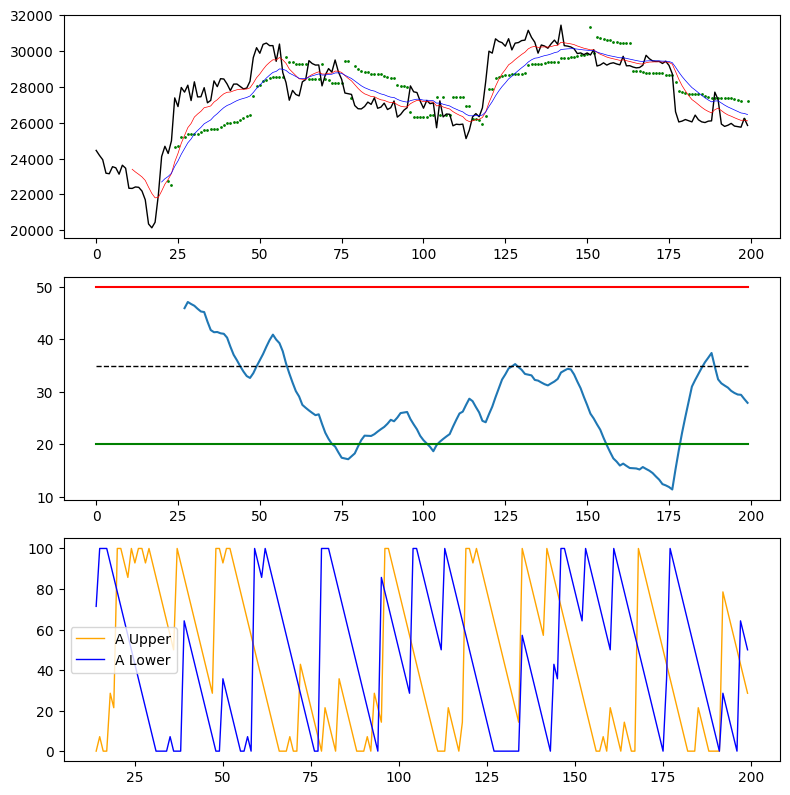

In [18]:
#plotting everything on a single graph
fig , axis = plt.subplots(3,1, figsize=(8,8))
#plotting main graph
axis[0].plot(ccxt_df['close'], label='Closes', linewidth="1", color='black')
axis[0].plot(indicators_df['EMA12'], label='EMA 12', linewidth="0.5", color='red')
axis[0].plot(indicators_df['EMA21'], label='EMA 21', linewidth="0.5", color='blue')
axis[0].scatter(indicators_df.index,indicators_df['vol_stop_longs'],label="Vol Stop", color='green',s = 1)
#plotting ADX
axis[1].plot(indicators_df['ADX'], label = 'ADX', linewidth="1.5")
min_valuex = [0,199]
min_valuey = [20,20]
axis[1].plot(min_valuex,min_valuey, color="green", linewidth="1.5")

max_valuex = [0,199]
max_valuey = [50,50]
axis[1].plot(max_valuex,max_valuey, color="red", linewidth="1.5")

mid_valuex = [0,199]
mid_valuey = [35,35]
axis[1].plot(mid_valuex,mid_valuey, linestyle="--", linewidth="1", color="black")

axis[2].plot(indicators_df['AroonU'], label='A Upper', color='orange', linewidth='1')
axis[2].plot(indicators_df['AroonD'], label='A Lower', color='blue', linewidth='1')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()